<a href="https://colab.research.google.com/github/ParthKhairnar101/Federated-Learning-Intrusion-Detection/blob/main/Intrusion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [2]:
# Load dataset
df = pd.read_csv(r'/content/KDDTrain+.txt', header=None)

# Displaying the first few rows of the dataset
df.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [3]:
# Assign column names (NSL-KDD dataset)
columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login",
    "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "attack_type", "difficulty_level"
]
df.columns = columns

In [4]:
# ✅ 1. Check for missing values
print("Missing Values:\n", df.isnull().sum().sum())  # Should be 0

Missing Values:
 0


In [5]:
# ✅ 2. Check for duplicates and remove them
df.drop_duplicates(inplace=True)
print("Duplicates removed. New shape:", df.shape)

Duplicates removed. New shape: (125973, 43)


In [6]:
# ✅ 3. Encode categorical features
label_encoders = {}
for col in ["protocol_type", "service", "flag"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store encoder for future use

In [7]:
# ✅ 4. Encode attack labels (Binary classification: normal = 0, attack = 1)
df["attack_label"] = df["attack_type"].apply(lambda x: 0 if x == "normal" else 1)

In [8]:
# ✅ 5. Encode Multi-Class Attack Labels
attack_mapping = {
    "normal": "normal",
    "neptune": "DoS", "smurf": "DoS", "teardrop": "DoS", "pod": "DoS", "land": "DoS", "back": "DoS",
    "satan": "Probe", "ipsweep": "Probe", "portsweep": "Probe", "nmap": "Probe",
    "guess_passwd": "R2L", "ftp_write": "R2L", "imap": "R2L", "phf": "R2L", "multihop": "R2L",
    "warezmaster": "R2L", "warezclient": "R2L", "spy": "R2L",
    "buffer_overflow": "U2R", "rootkit": "U2R", "loadmodule": "U2R", "perl": "U2R"
}
df["attack_category"] = df["attack_type"].map(attack_mapping)
df.drop(columns=["difficulty_level", "attack_type"], inplace=True)

In [9]:
# ✅ 6. Outlier Removal using IQR method
# Ensure all categorical columns are numeric
for col in ["protocol_type", "service", "flag"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Remove non-numeric columns before outlier detection
numeric_df = df.select_dtypes(include=[np.number]).copy()

# Outlier Removal using IQR
Q1 = numeric_df.quantile(0.25)
Q3 = numeric_df.quantile(0.75)
IQR = Q3 - Q1

# Define outlier condition
outlier_condition = (numeric_df < (Q1 - 1.5 * IQR)) | (numeric_df > (Q3 + 1.5 * IQR))

# Apply outlier removal
df_cleaned = df[~outlier_condition.any(axis=1)]

print("Original shape:", df.shape)
print("After outlier removal:", df_cleaned.shape)


Original shape: (125973, 43)
After outlier removal: (39077, 43)


In [10]:
# ✅ 7. Feature Scaling (Min-Max Scaling)
scaler = MinMaxScaler()

# Apply the scaler to all columns except the last two (presumably the labels or non-numeric columns)
df.iloc[:, :-2] = scaler.fit_transform(df.iloc[:, :-2])

# Display the first few rows to check if the scaling was applied correctly
df.head()

<ipython-input-10-060abe7a6add>:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0. 0. 0. ... 0. 0. 0.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:, :-2] = scaler.fit_transform(df.iloc[:, :-2])
<ipython-input-10-060abe7a6add>:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.5 1.  0.5 ... 0.5 0.5 0.5]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:, :-2] = scaler.fit_transform(df.iloc[:, :-2])
<ipython-input-10-060abe7a6add>:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.28985507 0.63768116 0.71014493 ... 0.7826087  0.43478261 0.28985507]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:, :-2] = scaler.fit_tran

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_label,attack_category
0,0.0,0.5,0.289855,0.9,3.558064e-07,0.000000e+00,0,0.0,0.0,0.0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0,normal
1,0.0,1.0,0.637681,0.9,1.057999e-07,0.000000e+00,0,0.0,0.0,0.0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0,normal
2,0.0,0.5,0.710145,0.5,0.000000e+00,0.000000e+00,0,0.0,0.0,0.0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1,DoS
3,0.0,0.5,0.347826,0.9,1.681203e-07,6.223962e-06,0,0.0,0.0,0.0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0,normal
4,0.0,0.5,0.347826,0.9,1.442067e-07,3.206260e-07,0,0.0,0.0,0.0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,normal


In [11]:
# ✅ 8. Handle Class Imbalance using SMOTE
X = df.drop(columns=["attack_label", "attack_category"])
y = df["attack_label"]
X_resampled, y_resampled = SMOTE().fit_resample(X, y)
print("After SMOTE:", X_resampled.shape, y_resampled.shape)

After SMOTE: (134686, 41) (134686,)


<ipython-input-12-e8498fe4bbb1>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["attack_label"], palette=["green", "red"])


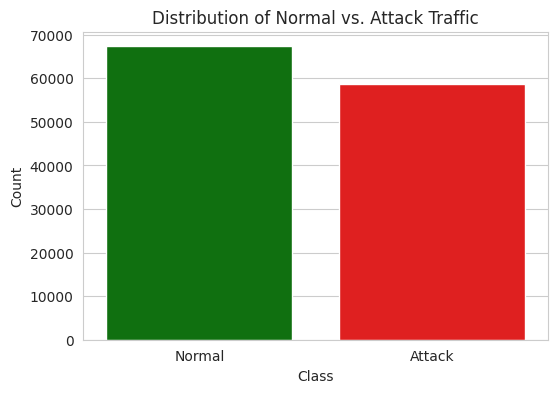

In [12]:
# ✅ 9. EDA: Visualizing class distribution
sns.set_style("whitegrid")
plt.figure(figsize=(6, 4))
sns.countplot(x=df["attack_label"], palette=["green", "red"])
plt.xticks(ticks=[0, 1], labels=["Normal", "Attack"])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Distribution of Normal vs. Attack Traffic")
plt.show()

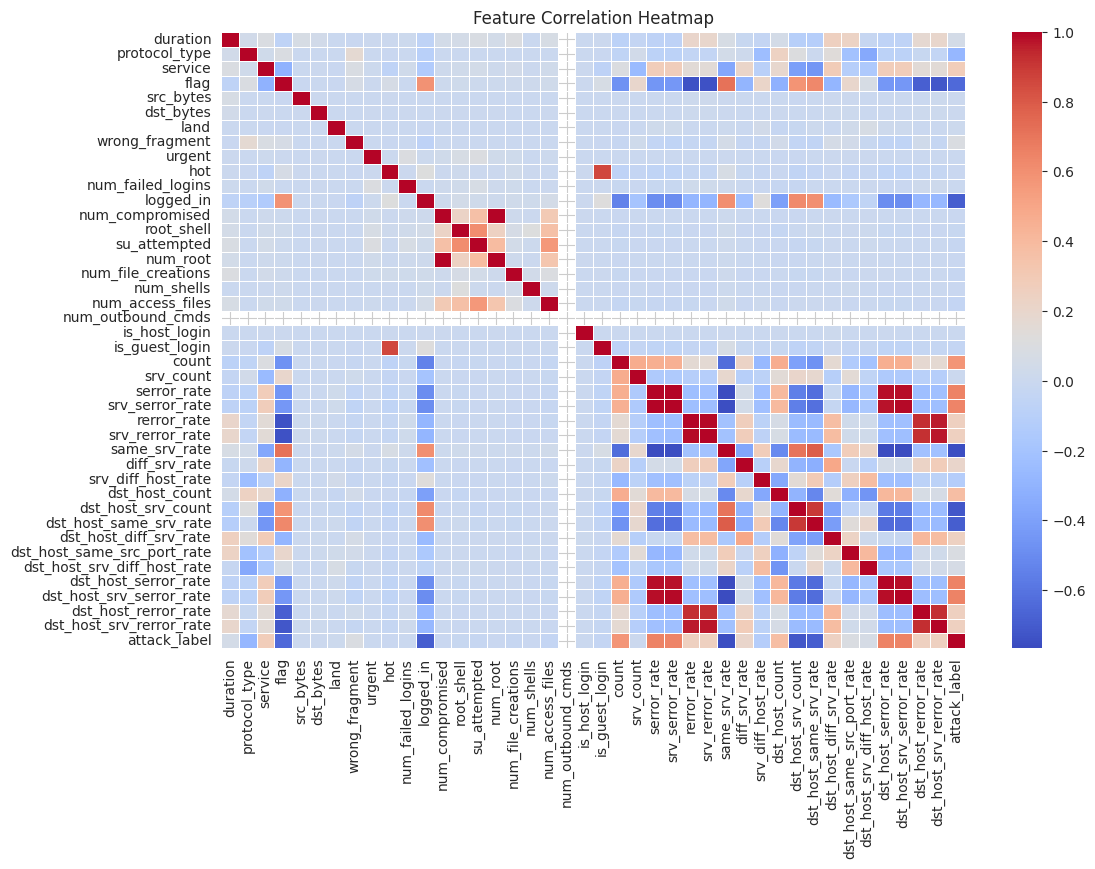

In [13]:
# ✅ 10. Feature Correlation Heatmap
# ✅ Remove non-numeric columns before correlation calculation
numeric_df = df.select_dtypes(include=[np.number])  # Keep only numeric features

# ✅ Compute and plot feature correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), cmap="coolwarm", linewidths=0.5, annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

<ipython-input-14-5c598d88d3a8>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df["service"].value_counts().index[:10], y=df["service"].value_counts().values[:10], palette="viridis")


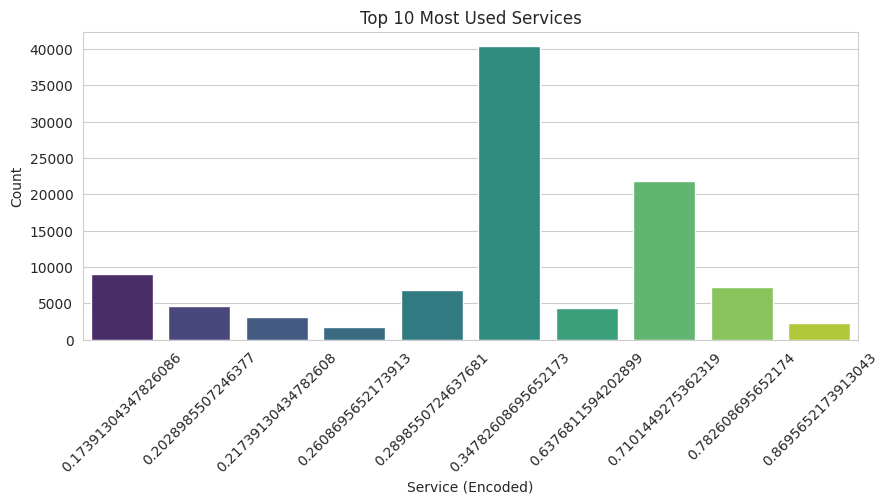

In [14]:
# ✅ 11. Top 10 most used services
plt.figure(figsize=(10, 4))
sns.barplot(x=df["service"].value_counts().index[:10], y=df["service"].value_counts().values[:10], palette="viridis")
plt.xlabel("Service (Encoded)")
plt.ylabel("Count")
plt.title("Top 10 Most Used Services")
plt.xticks(rotation=45)
plt.show()

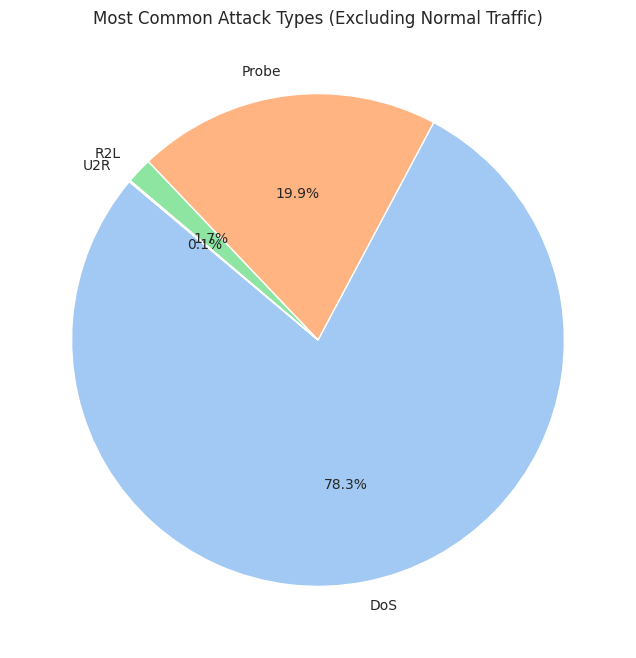

In [15]:
# ✅ Step 1: Count occurrences of each attack type
# ✅ Step 1: Count occurrences of each attack type, excluding "normal"
attack_counts = df[df["attack_category"] != "normal"]["attack_category"].value_counts()

# ✅ Step 2: Plot Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(attack_counts, labels=attack_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
plt.title("Most Common Attack Types (Excluding Normal Traffic)")
plt.show()

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import random

# model imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# processing imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from keras.layers import Dense, LSTM, MaxPool1D, Flatten, Dropout # importing dense layer
from keras.models import Sequential #importing Sequential layer
from keras.layers import Input
from keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D







# fetch the training file
file_path_20_percent = '/content/KDDTrain+_20Percent.txt'
file_path_full_training_set = '/content/KDDTrain+.txt'
file_path_test = '/content/KDDTest+.txt'

#df = pd.read_csv(file_path_20_percent)
df = pd.read_csv(file_path_full_training_set)
test_df = pd.read_csv(file_path_test)

# add the column labels
columns = (['duration'
,'protocol_type'
,'service'
,'flag'
,'src_bytes'
,'dst_bytes'
,'land'
,'wrong_fragment'
,'urgent'
,'hot'
,'num_failed_logins'
,'logged_in'
,'num_compromised'
,'root_shell'
,'su_attempted'
,'num_root'
,'num_file_creations'
,'num_shells'
,'num_access_files'
,'num_outbound_cmds'
,'is_host_login'
,'is_guest_login'
,'count'
,'srv_count'
,'serror_rate'
,'srv_serror_rate'
,'rerror_rate'
,'srv_rerror_rate'
,'same_srv_rate'
,'diff_srv_rate'
,'srv_diff_host_rate'
,'dst_host_count'
,'dst_host_srv_count'
,'dst_host_same_srv_rate'
,'dst_host_diff_srv_rate'
,'dst_host_same_src_port_rate'
,'dst_host_srv_diff_host_rate'
,'dst_host_serror_rate'
,'dst_host_srv_serror_rate'
,'dst_host_rerror_rate'
,'dst_host_srv_rerror_rate'
,'attack'
,'level'])

df.columns = columns
test_df.columns = columns

# map normal to 0, all attacks to 1
is_attack = df.attack.map(lambda a: 0 if a == 'normal' else 1)
test_attack = test_df.attack.map(lambda a: 0 if a == 'normal' else 1)

#data_with_attack = df.join(is_attack, rsuffix='_flag')
df['attack_flag'] = is_attack
test_df['attack_flag'] = test_attack

# lists to hold our attack classifications
dos_attacks = ['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm']
probe_attacks = ['ipsweep','mscan','nmap','portsweep','saint','satan']
privilege_attacks = ['buffer_overflow','loadmdoule','perl','ps','rootkit','sqlattack','xterm']
access_attacks = ['ftp_write','guess_passwd','http_tunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xclock','xsnoop']

# we will use these for plotting below
attack_labels = ['Normal','DoS','Probe','Privilege','Access']

# helper function to pass to data frame mapping
def map_attack(attack):
    if attack in dos_attacks:
        # dos_attacks map to 1
        attack_type = 1
    elif attack in probe_attacks:
        # probe_attacks mapt to 2
        attack_type = 2
    elif attack in privilege_attacks:
        # privilege escalation attacks map to 3
        attack_type = 3
    elif attack in access_attacks:
        # remote access attacks map to 4
        attack_type = 4
    else:
        # normal maps to 0
        attack_type = 0

    return attack_type

# map the data and join to the data set
attack_map = df.attack.apply(map_attack)
df['attack_map'] = attack_map

test_attack_map = test_df.attack.apply(map_attack)
test_df['attack_map'] = test_attack_map

le=LabelEncoder()
clm=['protocol_type', 'service', 'flag', 'attack']
for x in clm:
    df[x]=le.fit_transform(df[x])
    test_df[x]=le.fit_transform(test_df[x])

df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level,attack_flag,attack_map
0,0,2,44,9,146,0,0,0,0,0,...,0.88,0.00,0.00,0.00,0.00,0.00,11,15,0,0
1,0,1,49,5,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.00,0.00,9,19,1,1
2,0,1,24,9,232,8153,0,0,0,0,...,0.03,0.04,0.03,0.01,0.00,0.01,11,21,0,0
3,0,1,24,9,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,11,21,0,0
4,0,1,49,1,0,0,0,0,0,0,...,0.00,0.00,0.00,0.00,1.00,1.00,9,21,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125967,0,1,49,5,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.00,0.00,9,20,1,1
125968,8,2,49,9,105,145,0,0,0,0,...,0.01,0.00,0.00,0.00,0.00,0.00,11,21,0,0
125969,0,1,54,9,2231,384,0,0,0,0,...,0.00,0.00,0.72,0.00,0.01,0.00,11,18,0,0
125970,0,1,30,5,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.00,0.00,9,20,1,1


In [17]:
x_train=df.drop('attack_flag',axis=1)
x_train=x_train.drop('attack',axis=1)
x_train=x_train.drop('attack_map',axis=1)
x_train=x_train.drop('level',axis=1)
y_train=df[['attack_flag']]



X_train, X_test, Y_train, Y_test = train_test_split(x_train,y_train, test_size=0.20, random_state=42)


# Convolution
kernel_size = 5
filters = 64
pool_size = 4

# LSTM
lstm_output_size = 70

# Training
batch_size = 30
epochs = 2

X_train = np.array(X_train)
X_test = np.array(X_test)
#cnn-input
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#lstm-input
# X_train = np.reshape(X_train, ( X_train.shape[0], 1 , X_train.shape[1] ))
Y_train = np.array(Y_train)

model = Sequential() # initializing model
# cnn-lstm
model.add(Conv1D(32, 9, padding="same",input_shape = (X_train.shape[1], 1), activation='relu'))
model.add(MaxPool1D(pool_size=(2)))
model.add(LSTM(units=16,return_sequences=False,dropout=0.2))
model.add(Dense(units=1))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history=model.fit(X_train, Y_train, epochs=10, batch_size=250,validation_split=0.1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7668 - loss: 1.1284 - val_accuracy: 0.8568 - val_loss: 0.3183
Epoch 2/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8906 - loss: 0.2602 - val_accuracy: 0.9276 - val_loss: 0.2108
Epoch 3/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9322 - loss: 0.1986 - val_accuracy: 0.9416 - val_loss: 0.1700
Epoch 4/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9404 - loss: 0.1655 - val_accuracy: 0.9464 - val_loss: 0.1579
Epoch 5/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9440 - loss: 0.1615 - val_accuracy: 0.9494 - val_loss: 0.1474
Epoch 6/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9516 - loss: 0.1472 - val_accuracy: 0.9355 - val_loss: 0.1443
Epoch 7/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9465 - loss: 0.1404 - val_accuracy: 0.9572 - val_loss: 0.1117
Epoch 8/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9546 - loss: 0.1268 - val_accuracy: 0.

In [18]:
# Reshape the test data for CNN-LSTM
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
Y_test = np.array(Y_test)

test_results = model.evaluate(X_test, Y_test, verbose=1)

788/788 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9585 - loss: 0.1187


Text(0, 0.5, 'Loss')

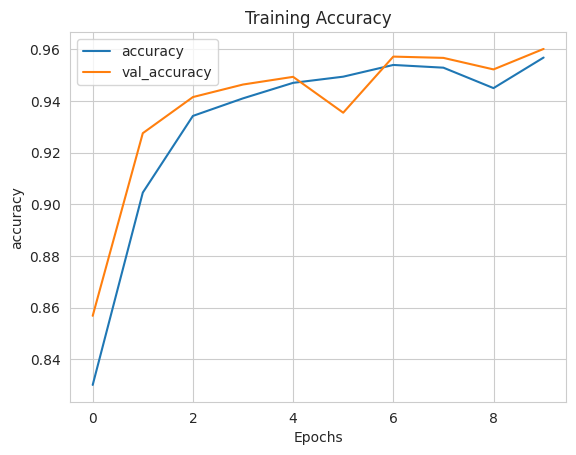

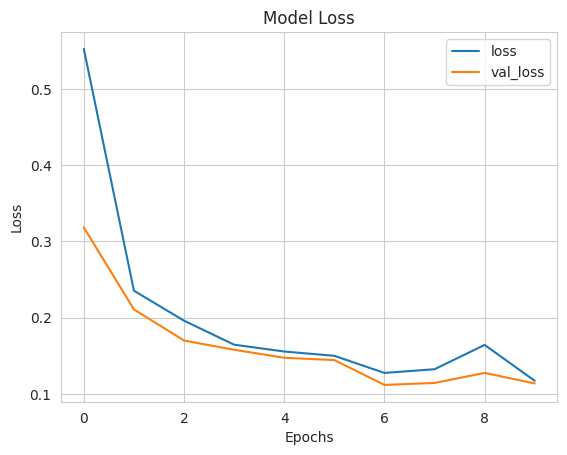

In [19]:
pd.DataFrame(history.history)

pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')

pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [20]:
from sklearn.metrics import classification_report

Y_predict = model.predict(X_test)
Y_pred = Y_predict.argmax(axis=-1)
Y_test = Y_test.argmax(axis = -1 )
report = classification_report(Y_test, Y_pred)
print(report)

788/788 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25195

    accuracy                           1.00     25195
   macro avg       1.00      1.00      1.00     25195
weighted avg       1.00      1.00      1.00     25195



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


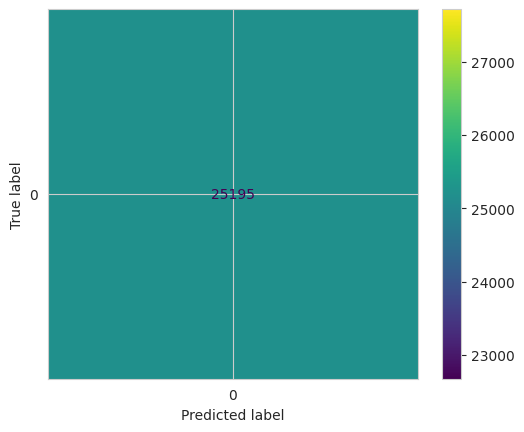

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# compute the confusion matrix
cm = confusion_matrix(Y_test, Y_pred)

# create a ConfusionMatrixDisplay object
cm_display = ConfusionMatrixDisplay(cm)

# plot the confusion matrix
cm_display.plot()
plt.show()

In [22]:
model.save("CNN-LSTM, NSL-KDD, Binary-class, 2022.h5")

In [28]:
!pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.6 which is incompatible.
ydf 0.11.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 4.25.6 which is incompatible.


In [30]:
!pip install --upgrade protobuf==5.29.2

  Using cached protobuf-5.29.2-cp38-abi3-manylinux2014_x86_64.whl.metadata (592 bytes)
Using cached protobuf-5.29.2-cp38-abi3-manylinux2014_x86_64.whl (319 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flwr 1.17.0 requires protobuf<5.0.0,>=4.21.6, but you have protobuf 5.29.2 which is incompatible.


In [31]:
!pip install --upgrade fsspec==2025.3.2

In [33]:
!pip install --upgrade cryptography==43.0.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 31.5 MB/s eta 0:00:00
  Attempting uninstall: cryptography
    Found existing installation: cryptography 44.0.2
    Uninstalling cryptography-44.0.2:
      Successfully uninstalled cryptography-44.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flwr 1.17.0 requires cryptography<45.0.0,>=44.0.1, but you have cryptography 43.0.3 which is incompatible.
flwr 1.17.0 requires protobuf<5.0.0,>=4.21.6, but you have protobuf 5.29.2 which is incompatible.


In [34]:
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

Training on cuda
Flower 1.17.0 / PyTorch 2.6.0+cu124


    f0   f1    f2   f3     f4      f5   f6   f7   f8   f9  ...    f32   f33  \
0  0.0  1.0  49.0  5.0    0.0     0.0  0.0  0.0  0.0  0.0  ...    2.0  0.01   
1  0.0  2.0  12.0  9.0   33.0    93.0  0.0  0.0  0.0  0.0  ...  242.0  0.95   
2  0.0  1.0  24.0  9.0  343.0  4154.0  0.0  0.0  0.0  0.0  ...  255.0  1.00   
3  0.0  1.0  24.0  9.0  307.0  1088.0  0.0  0.0  0.0  0.0  ...  255.0  1.00   
4  0.0  1.0  24.0  9.0  345.0  2090.0  0.0  0.0  0.0  0.0  ...  255.0  1.00   

    f34   f35   f36  f37  f38  f39  f40  attack_flag  
0  0.07  0.00  0.00  1.0  1.0  0.0  0.0            1  
1  0.01  0.01  0.00  0.0  0.0  0.0  0.0            0  
2  0.00  0.00  0.00  0.0  0.0  0.0  0.0            0  
3  0.00  0.11  0.02  0.0  0.0  0.0  0.0            0  
4  0.00  0.00  0.00  0.0  0.0  0.0  0.0            0  

[5 rows x 42 columns]


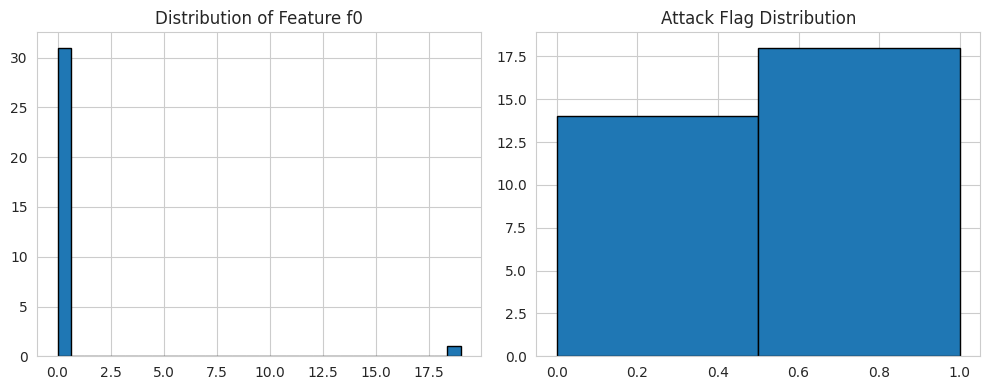

In [35]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

# Set batch size (you can adjust as needed)
BATCH_SIZE = 32

def load_tabular_dataset():
    """
    Create a tf.data.Dataset from X_train and Y_train,
    shuffle the data, and batch it.
    """
    dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
    dataset = dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE)
    return dataset

# Load dataset and grab one batch (simulate one client partition)
train_dataset = load_tabular_dataset()
batch = next(iter(train_dataset))

# Extract features and labels from the batch
features_batch, labels_batch = batch
# Remove the last singleton dimension for ease of display (if desired)
features_batch = tf.squeeze(features_batch, axis=-1)

# Convert the batch to a pandas DataFrame
num_features = features_batch.shape[1]
feature_columns = [f"f{i}" for i in range(num_features)]
df_batch = pd.DataFrame(features_batch.numpy(), columns=feature_columns)
df_batch["attack_flag"] = labels_batch.numpy()

# Display the first few rows of the batch
print(df_batch.head())

# Optionally, plot the distribution of one or two features for inspection
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(df_batch["f0"], bins=30, edgecolor="k")
plt.title("Distribution of Feature f0")
plt.subplot(1, 2, 2)
plt.hist(df_batch["attack_flag"], bins=2, edgecolor="k")
plt.title("Attack Flag Distribution")
plt.tight_layout()
plt.show()

In [61]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disable GPU if causing cuDNN issues

In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPool1D, LSTM, Dense, Dropout

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, TimeDistributed, Input

def create_model():
    model = Sequential()
    model.add(TimeDistributed(Dense(64), input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=16, return_sequences=False, dropout=0.2))
    model.add(Dense(units=1, activation='sigmoid'))  # Binary classification
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Verify that the model summary looks correct:
model = create_model()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 41, 64)         │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 16)             │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,329 (20.82 KB)

 Trainable params: 5,329 (20.82 KB)

 Non-trainable params: 0 (0.00 B)

In [63]:
def train_model(model, train_dataset, epochs, verbose=True):
    """Train the model using the provided dataset for a specified number of epochs."""
    history = model.fit(train_dataset, epochs=epochs, verbose=verbose)
    return history

def evaluate_model(model, dataset):
    """Evaluate the model on the provided dataset."""
    loss, accuracy = model.evaluate(dataset, verbose=0)
    return loss, accuracy

In [64]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

BATCH_SIZE = 32

# Split X_train and Y_train into training and validation sets (80-20 split)
X_tr, X_val, Y_tr, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

# Create tf.data.Datasets for training, validation, and testing
train_ds = tf.data.Dataset.from_tensor_slices((X_tr, Y_tr)).batch(BATCH_SIZE)
val_ds   = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).batch(BATCH_SIZE)

# Reshape X_test to match the input shape expected by the model
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
# Reshape Y_test to have an extra dimension for the model to work properly.
Y_test_reshaped = Y_test.reshape(-1, 1) # -1 means infer the first dimension
test_ds  = tf.data.Dataset.from_tensor_slices((X_test_reshaped, Y_test_reshaped)).batch(BATCH_SIZE)


# Initialize a new instance of the CNN-LSTM model
model = create_model()

# Train for 5 epochs, evaluating on the validation dataset after each epoch
for epoch in range(5):
    print(f"\nEpoch {epoch+1}")
    train_model(model, train_ds, epochs=1, verbose=True)
    val_loss, val_acc = evaluate_model(model, val_ds)
    print(f"Validation loss: {val_loss:.4f}, Validation accuracy: {val_acc:.4f}")

# Finally, evaluate the model on the test dataset
test_loss, test_acc = evaluate_model(model, test_ds)
print(f"\nFinal Test Set Performance:\n\tLoss: {test_loss:.4f}\n\tAccuracy: {test_acc:.4f}")


Epoch 1
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - accuracy: 0.9006 - loss: 0.2580
Validation loss: 0.1111, Validation accuracy: 0.9628

Epoch 2
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.9638 - loss: 0.1025
Validation loss: 0.0826, Validation accuracy: 0.9705

Epoch 3
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.9688 - loss: 0.0891
Validation loss: 0.0790, Validation accuracy: 0.9724

Epoch 4
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.9737 - loss: 0.0765
Validation loss: 0.0737, Validation accuracy: 0.9748

Epoch 5
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.9766 - loss: 0.0701
Validation loss: 0.0620, Validation accuracy: 0.9771

Final Test Set Performance:
	Loss: 2.5160
	Accuracy: 0.5346


In [66]:
from typing import List
import numpy as np

def set_parameters(model, parameters: List[np.ndarray]):
    """Set model weights from the given list of NumPy arrays."""
    model.set_weights(parameters)

def get_parameters(model) -> List[np.ndarray]:
    """Return model weights as a list of NumPy arrays."""
    return model.get_weights()

In [67]:
import flwr as fl

# Flower client using Keras; assumes you have already defined train_model and evaluate_model functions.
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, model, train_ds, val_ds):
        self.model = model
        self.train_ds = train_ds
        self.val_ds = val_ds

    def get_parameters(self, config):
        return get_parameters(self.model)

    def fit(self, parameters, config):
        set_parameters(self.model, parameters)
        # Train for one epoch (or adjust as necessary)
        train_model(self.model, self.train_ds, epochs=1, verbose=True)
        # Return updated weights along with sample count and empty metrics dict
        return get_parameters(self.model), sum(1 for _ in self.train_ds), {}

    def evaluate(self, parameters, config):
        set_parameters(self.model, parameters)
        loss, accuracy = evaluate_model(self.model, self.val_ds)
        return float(loss), sum(1 for _ in self.val_ds), {"accuracy": float(accuracy)}

In [68]:
def client_fn(cid: str) -> fl.client.Client:
    """
    Create a FlowerClient with its own data partition.
    cid: client ID (e.g., '0', '1', ...)
    """
    cid = int(cid)
    num_clients = NUM_CLIENTS
    client_size = len(X_train) // num_clients

    start = cid * client_size
    end = (cid + 1) * client_size if cid < num_clients - 1 else len(X_train)

    # Slice client-specific data
    X_client = X_train[start:end]
    Y_client = Y_train[start:end]

    # Reshape for CNN-LSTM model
    X_client = X_client.reshape((X_client.shape[0], X_client.shape[1], 1))
    Y_client = Y_client.reshape((-1, 1))

    # Train/Val split (e.g., 80% train, 20% val)
    X_tr, X_val, Y_tr, Y_val = train_test_split(X_client, Y_client, test_size=0.2, random_state=42)

    # Create tf.data.Dataset objects
    train_ds = tf.data.Dataset.from_tensor_slices((X_tr, Y_tr)).batch(32)
    val_ds = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).batch(32)

    model = create_model()
    return FlowerClient(model, train_ds, val_ds)

In [69]:
client = client_fn("0")
params = client.get_parameters({})
client.fit(params, {})
client.evaluate(params, {})

252/252 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7687 - loss: 0.5275


(0.6989315152168274, 63, {'accuracy': 0.5292658805847168})

In [70]:
import tensorflow as tf
import flwr as fl
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt

# ====== 1. Accuracy log to visualize later ======
accuracy_per_round = []

# ====== 2. Strategy with custom aggregation and logging ======
def weighted_average(metrics: List[Tuple[int, Dict[str, float]]]) -> Dict[str, float]:
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    total_examples = sum(num_examples for num_examples, _ in metrics)
    round_accuracy = sum(accuracies) / total_examples
    accuracy_per_round.append(round_accuracy)  # Store for graphing
    print(f"🔁 Round {len(accuracy_per_round)} - Weighted Accuracy: {round_accuracy:.4f}")
    return {"accuracy": round_accuracy}

strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average
)

# ====== 3. Client resources setup ======
if tf.config.list_physical_devices("GPU"):
    client_resources = {"num_cpus": 1, "num_gpus": 1.0}
else:
    client_resources = {"num_cpus": 1, "num_gpus": 0.0}

# ====== 4. Run the simulation and log history ======
hist = fl.simulation.start_simulation(
    client_fn=client_fn,                              # Your defined client function
    num_clients=NUM_CLIENTS,                          # Total clients to simulate
    config=fl.server.ServerConfig(num_rounds=5),      # Federated training config
    strategy=strategy,                                # Strategy with accuracy logging
    client_resources=client_resources,                # Resource allocation
)

	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=5, no round_timeout
2025-04-10 19:39:14,143	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 2.0, 'object_store_memory': 3972098457.0, 'node:172.28.0.12': 1.0, 'memory': 7944196916.0, 'accelerator_type:T4': 1.0, 'GPU': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 1.0}
INFO :      Flow

  5/252 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5348 - loss: 0.6907 
 15/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5177 - loss: 0.6882
 25/252 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5453 - loss: 0.6839
 34/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5750 - loss: 0.6791
 44/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6034 - loss: 0.6735
 49/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6169 - loss: 0.6705
 59/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6406 - loss: 0.6640
 69/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6610 - loss: 0.6571
 79/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6786 - loss: 0.6494
 89/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6936 - loss: 0.6411
 94/252 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7003 - loss: 0.6368
104/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7121 - loss: 0.6281
114/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7224 - loss: 0.6195
123/252 ━━━

(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=27876) 
(ClientAppActor pid=27876)             This is a deprecated feature. It will be removed
(ClientAppActor pid=27876)             entirely in future versions of Flower.
(ClientAppActor pid=27876)         
(ClientAppActor pid=27876) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


  6/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4496 - loss: 0.7014 
 16/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4891 - loss: 0.6930
 21/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5147 - loss: 0.6895
 31/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5654 - loss: 0.6826
 37/252 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5889 - loss: 0.6787
 40/252 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5991 - loss: 0.6768
 45/252 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6145 - loss: 0.6736
 51/252 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6309 - loss: 0.6697
 57/252 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6459 - loss: 0.6653
 63/252 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6594 - loss: 0.6607
 66/252 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6656 - loss: 0.6582
 72/252 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6769 - loss: 0.6532
 75/252 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6820 - loss: 0.6506
 81/252 ━━━

(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=27876) 
(ClientAppActor pid=27876)             This is a deprecated feature. It will be removed
(ClientAppActor pid=27876)             entirely in future versions of Flower.
(ClientAppActor pid=27876)         
(ClientAppActor pid=27876) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


  1/253 ━━━━━━━━━━━━━━━━━━━━ 11:28 3s/step - accuracy: 0.5000 - loss: 0.6933
 11/253 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5185 - loss: 0.6915
 19/253 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5471 - loss: 0.6878
 29/253 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5732 - loss: 0.6833
 34/253 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5856 - loss: 0.6809
 44/253 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6110 - loss: 0.6757
 54/253 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6346 - loss: 0.6702
 59/253 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6449 - loss: 0.6672
 69/253 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6637 - loss: 0.6606
 79/253 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6798 - loss: 0.6532
 89/253 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6940 - loss: 0.6450
 98/253 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7052 - loss: 0.6372
102/253 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7097 - loss: 0.6336
112/253 ━━━

(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=27876) 
(ClientAppActor pid=27876)             This is a deprecated feature. It will be removed
(ClientAppActor pid=27876)             entirely in future versions of Flower.
(ClientAppActor pid=27876)         
(ClientAppActor pid=27876) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


  6/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5269 - loss: 0.6882 
 16/252 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5316 - loss: 0.6858
 26/252 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5630 - loss: 0.6821
 36/252 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5959 - loss: 0.6780
 41/252 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6105 - loss: 0.6757
 50/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6319 - loss: 0.6713
 60/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6523 - loss: 0.6659
 70/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6702 - loss: 0.6599
 75/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6783 - loss: 0.6565
 85/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6932 - loss: 0.6491
 95/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7060 - loss: 0.6410
104/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7160 - loss: 0.6334
107/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7191 - loss: 0.6308
113/252 ━━━

(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=27876) 
(ClientAppActor pid=27876)             This is a deprecated feature. It will be removed
(ClientAppActor pid=27876)             entirely in future versions of Flower.
(ClientAppActor pid=27876)         
(ClientAppActor pid=27876) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


  1/252 ━━━━━━━━━━━━━━━━━━━━ 11:47 3s/step - accuracy: 0.5000 - loss: 0.7016
 11/252 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5401 - loss: 0.6872
 21/252 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5415 - loss: 0.6824
 31/252 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5514 - loss: 0.6786
 36/252 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5634 - loss: 0.6764
 46/252 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5895 - loss: 0.6708
 55/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6109 - loss: 0.6657
 64/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6301 - loss: 0.6598
 74/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6487 - loss: 0.6525
 79/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6570 - loss: 0.6486
 89/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6721 - loss: 0.6404
 99/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6854 - loss: 0.6319
109/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6971 - loss: 0.6234
119/252 ━━━

(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=27876) 
(ClientAppActor pid=27876)             This is a deprecated feature. It will be removed
(ClientAppActor pid=27876)             entirely in future versions of Flower.
(ClientAppActor pid=27876)         
(ClientAppActor pid=27876) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


  1/252 ━━━━━━━━━━━━━━━━━━━━ 11:21 3s/step - accuracy: 0.3750 - loss: 0.7042
 11/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4786 - loss: 0.6950
 21/252 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5176 - loss: 0.6900
 31/252 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5572 - loss: 0.6852
 41/252 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5877 - loss: 0.6805
 51/252 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6144 - loss: 0.6752
 56/252 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6264 - loss: 0.6722
 66/252 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6472 - loss: 0.6659
 76/252 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6646 - loss: 0.6590
 86/252 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6795 - loss: 0.6514
 90/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6850 - loss: 0.6482
100/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6974 - loss: 0.6397
110/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7083 - loss: 0.6310
119/252 ━━━

(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=27876) 
(ClientAppActor pid=27876)             This is a deprecated feature. It will be removed
(ClientAppActor pid=27876)             entirely in future versions of Flower.
(ClientAppActor pid=27876)         
(ClientAppActor pid=27876) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


  6/252 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5549 - loss: 0.6882 
 16/252 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5258 - loss: 0.6884
 26/252 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5434 - loss: 0.6846
 31/252 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5578 - loss: 0.6822
 41/252 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5840 - loss: 0.6771
 51/252 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6039 - loss: 0.6716
 61/252 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6216 - loss: 0.6654
 70/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6364 - loss: 0.6591
 75/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6440 - loss: 0.6555
 85/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6580 - loss: 0.6478
 95/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6709 - loss: 0.6393
105/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6826 - loss: 0.6302
115/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6932 - loss: 0.6207
120/252 ━━━

(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=27876) 
(ClientAppActor pid=27876)             This is a deprecated feature. It will be removed
(ClientAppActor pid=27876)             entirely in future versions of Flower.
(ClientAppActor pid=27876)         
(ClientAppActor pid=27876) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


  1/252 ━━━━━━━━━━━━━━━━━━━━ 11:34 3s/step - accuracy: 0.4062 - loss: 0.7023
 11/252 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4691 - loss: 0.6954
 21/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5342 - loss: 0.6880
 31/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5784 - loss: 0.6814
 36/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5939 - loss: 0.6781
 45/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6158 - loss: 0.6722
 55/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6355 - loss: 0.6654
 65/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6526 - loss: 0.6581
 75/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6679 - loss: 0.6501
 80/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6750 - loss: 0.6457
 90/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6882 - loss: 0.6365
100/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7000 - loss: 0.6269
109/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7094 - loss: 0.6184
118/252 ━━━

(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=27876) 
(ClientAppActor pid=27876)             This is a deprecated feature. It will be removed
(ClientAppActor pid=27876)             entirely in future versions of Flower.
(ClientAppActor pid=27876)         
(ClientAppActor pid=27876) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


  1/252 ━━━━━━━━━━━━━━━━━━━━ 12:46 3s/step - accuracy: 0.4375 - loss: 0.6993
 11/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5263 - loss: 0.6912
 21/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5591 - loss: 0.6857
 30/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5867 - loss: 0.6811
 39/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6145 - loss: 0.6764
 43/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6261 - loss: 0.6742
 53/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6509 - loss: 0.6685
 63/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6719 - loss: 0.6622
 73/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6893 - loss: 0.6553
 82/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7030 - loss: 0.6485
 92/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7164 - loss: 0.6402
 97/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7224 - loss: 0.6359
107/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7334 - loss: 0.6270
117/252 ━━━

(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=27876) 
(ClientAppActor pid=27876)             This is a deprecated feature. It will be removed
(ClientAppActor pid=27876)             entirely in future versions of Flower.
(ClientAppActor pid=27876)         
(ClientAppActor pid=27876) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


  1/252 ━━━━━━━━━━━━━━━━━━━━ 11:29 3s/step - accuracy: 0.4688 - loss: 0.7016
 10/252 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5071 - loss: 0.6940
 14/252 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5243 - loss: 0.6917
 24/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5644 - loss: 0.6857
 34/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5893 - loss: 0.6798
 43/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6055 - loss: 0.6743
 52/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6192 - loss: 0.6685
 61/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6313 - loss: 0.6625
 69/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6421 - loss: 0.6569
 74/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6486 - loss: 0.6532
 83/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6599 - loss: 0.6460
 92/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6703 - loss: 0.6384
102/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6809 - loss: 0.6296
112/252 ━━━

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


252/252 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.7711 - loss: 0.5164


(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=27876) 
(ClientAppActor pid=27876)             This is a deprecated feature. It will be removed
(ClientAppActor pid=27876)             entirely in future versions of Flower.
(ClientAppActor pid=27876)         
(ClientAppActor pid=27876) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.c

🔁 Round 1 - Weighted Accuracy: 0.8991
  1/252 ━━━━━━━━━━━━━━━━━━━━ 11:42 3s/step - accuracy: 0.9062 - loss: 0.3716
  6/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9062 - loss: 0.3045 
 16/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8949 - loss: 0.3033
 26/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9005 - loss: 0.2860
 36/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9034 - loss: 0.2757
 44/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9043 - loss: 0.2713
 47/252 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9047 - loss: 0.2698
 53/252 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9055 - loss: 0.2669
 59/252 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9061 - loss: 0.2645
 65/252 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9067 - loss: 0.2626
 68/252 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9071 - loss: 0.2615
 74/252 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9079 - loss: 0.2593
 80/252 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accu

(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=27876) 
(ClientAppActor pid=27876)             This is a deprecated feature. It will be removed
(ClientAppActor pid=27876)             entirely in future versions of Flower.
(ClientAppActor pid=27876)         
(ClientAppActor pid=27876) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


  1/252 ━━━━━━━━━━━━━━━━━━━━ 11:30 3s/step - accuracy: 0.8750 - loss: 0.3327
 11/252 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9085 - loss: 0.3177
 21/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9119 - loss: 0.2989
 26/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9127 - loss: 0.2947
 31/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9137 - loss: 0.2908
 35/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9142 - loss: 0.2886
 45/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9147 - loss: 0.2840
 55/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9156 - loss: 0.2790
 64/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9159 - loss: 0.2761
 69/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9161 - loss: 0.2745
 79/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9168 - loss: 0.2709
 89/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9175 - loss: 0.2676
 98/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9179 - loss: 0.2655
108/252 ━━━

(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=27876) 
(ClientAppActor pid=27876)             This is a deprecated feature. It will be removed
(ClientAppActor pid=27876)             entirely in future versions of Flower.
(ClientAppActor pid=27876)         
(ClientAppActor pid=27876) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


  1/252 ━━━━━━━━━━━━━━━━━━━━ 11:27 3s/step - accuracy: 0.8750 - loss: 0.3891
 11/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8912 - loss: 0.3217
 21/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9018 - loss: 0.2952
 30/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9065 - loss: 0.2817
 40/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9082 - loss: 0.2757
 45/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9085 - loss: 0.2739
 53/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9086 - loss: 0.2726
 60/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9090 - loss: 0.2711
 66/252 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9093 - loss: 0.2700
 69/252 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9094 - loss: 0.2695
 75/252 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9094 - loss: 0.2689
 81/252 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9093 - loss: 0.2685
 84/252 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9093 - loss: 0.2683
 90/252 ━━━

(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=27876) 
(ClientAppActor pid=27876)             This is a deprecated feature. It will be removed
(ClientAppActor pid=27876)             entirely in future versions of Flower.
(ClientAppActor pid=27876)         
(ClientAppActor pid=27876) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


  1/252 ━━━━━━━━━━━━━━━━━━━━ 11:38 3s/step - accuracy: 0.9375 - loss: 0.2821
 10/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9224 - loss: 0.2564
 18/252 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9231 - loss: 0.2496
 28/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9223 - loss: 0.2471
 38/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9202 - loss: 0.2478
 42/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9198 - loss: 0.2474
 51/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9184 - loss: 0.2471
 60/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9178 - loss: 0.2468
 70/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9176 - loss: 0.2461
 79/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9178 - loss: 0.2448
 89/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9179 - loss: 0.2433
 98/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9182 - loss: 0.2419
103/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9184 - loss: 0.2411
112/252 ━━━

(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=27876) 
(ClientAppActor pid=27876)             This is a deprecated feature. It will be removed
(ClientAppActor pid=27876)             entirely in future versions of Flower.
(ClientAppActor pid=27876)         
(ClientAppActor pid=27876) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


  1/252 ━━━━━━━━━━━━━━━━━━━━ 11:42 3s/step - accuracy: 0.9688 - loss: 0.2133
  6/252 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9379 - loss: 0.2386 
 16/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9218 - loss: 0.2536
 25/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9162 - loss: 0.2615
 35/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9134 - loss: 0.2676
 45/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9125 - loss: 0.2705
 50/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9124 - loss: 0.2707
 59/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9125 - loss: 0.2701
 69/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9123 - loss: 0.2699
 75/252 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9121 - loss: 0.2701
 78/252 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9120 - loss: 0.2702
 84/252 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9118 - loss: 0.2702
 90/252 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9116 - loss: 0.2703
 96/252 ━━

(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=27876) 
(ClientAppActor pid=27876)             This is a deprecated feature. It will be removed
(ClientAppActor pid=27876)             entirely in future versions of Flower.
(ClientAppActor pid=27876)         
(ClientAppActor pid=27876) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


  1/253 ━━━━━━━━━━━━━━━━━━━━ 11:32 3s/step - accuracy: 0.8438 - loss: 0.4958
 11/253 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8991 - loss: 0.3266
 21/253 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9042 - loss: 0.3054
 30/253 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9070 - loss: 0.2974
 35/253 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9079 - loss: 0.2943
 45/253 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9091 - loss: 0.2889
 55/253 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9099 - loss: 0.2852
 64/253 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9104 - loss: 0.2826
 69/253 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9107 - loss: 0.2814
 79/253 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9108 - loss: 0.2800
 88/253 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9109 - loss: 0.2786
 98/253 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9111 - loss: 0.2769
108/253 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9114 - loss: 0.2752
112/253 ━━━

(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=27876) 
(ClientAppActor pid=27876)             This is a deprecated feature. It will be removed
(ClientAppActor pid=27876)             entirely in future versions of Flower.
(ClientAppActor pid=27876)         
(ClientAppActor pid=27876) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


  6/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8481 - loss: 0.4057 
 16/252 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8659 - loss: 0.3712
 25/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8748 - loss: 0.3539
 29/252 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8762 - loss: 0.3506
 35/252 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8776 - loss: 0.3455
 41/252 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8793 - loss: 0.3396
 47/252 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8806 - loss: 0.3349
 50/252 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8813 - loss: 0.3328
 56/252 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8827 - loss: 0.3289
 62/252 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8839 - loss: 0.3252
 65/252 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8843 - loss: 0.3236
 71/252 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8850 - loss: 0.3206
 77/252 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8857 - loss: 0.3177
 80/252 ━━━

(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=27876) 
(ClientAppActor pid=27876)             This is a deprecated feature. It will be removed
(ClientAppActor pid=27876)             entirely in future versions of Flower.
(ClientAppActor pid=27876)         
(ClientAppActor pid=27876) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


  1/252 ━━━━━━━━━━━━━━━━━━━━ 11:25 3s/step - accuracy: 0.9062 - loss: 0.2814
 10/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9123 - loss: 0.2595
 20/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9061 - loss: 0.2705
 28/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9061 - loss: 0.2712
 38/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9061 - loss: 0.2703
 43/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9064 - loss: 0.2692
 48/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9066 - loss: 0.2687
 53/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9069 - loss: 0.2677
 62/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9075 - loss: 0.2657
 72/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9085 - loss: 0.2632
 82/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9092 - loss: 0.2616
 87/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9095 - loss: 0.2608
 97/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9101 - loss: 0.2589
107/252 ━━━

(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=27876) 
(ClientAppActor pid=27876)             This is a deprecated feature. It will be removed
(ClientAppActor pid=27876)             entirely in future versions of Flower.
(ClientAppActor pid=27876)         
(ClientAppActor pid=27876) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


  6/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9300 - loss: 0.2304 
 16/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9154 - loss: 0.2514
 26/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9120 - loss: 0.2582
 35/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9101 - loss: 0.2640
 40/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9096 - loss: 0.2656
 48/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9090 - loss: 0.2668
 54/252 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9090 - loss: 0.2665
 59/252 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9087 - loss: 0.2669
 62/252 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9086 - loss: 0.2672
 68/252 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9084 - loss: 0.2675
 73/252 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9083 - loss: 0.2678
 79/252 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9081 - loss: 0.2682
 84/252 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9079 - loss: 0.2685
 87/252 ━━━

(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=27876) 
(ClientAppActor pid=27876)             This is a deprecated feature. It will be removed
(ClientAppActor pid=27876)             entirely in future versions of Flower.
(ClientAppActor pid=27876)         
(ClientAppActor pid=27876) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


  6/252 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8609 - loss: 0.3757 
 15/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8758 - loss: 0.3331
 25/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8821 - loss: 0.3239
 34/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8866 - loss: 0.3165
 39/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8885 - loss: 0.3128
 48/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8917 - loss: 0.3064
 58/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8940 - loss: 0.3016
 63/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8948 - loss: 0.2995
 73/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8960 - loss: 0.2964
 83/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8974 - loss: 0.2927
 93/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8988 - loss: 0.2891
 98/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8995 - loss: 0.2873
108/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9006 - loss: 0.2839
118/252 ━━━

INFO :      aggregate_fit: received 10 results and 0 failures


238/252 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9082 - loss: 0.2601
248/252 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9086 - loss: 0.2588


INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=27876) 
(ClientAppActor pid=27876)             This is a deprecated feature. It will be removed
(ClientAppActor pid=27876)             entirely in future versions of Flower.
(ClientAppActor pid=27876)         
(ClientAppActor pid=27876) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


252/252 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9088 - loss: 0.2581


(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=27876) 
(ClientAppActor pid=27876)             This is a deprecated feature. It will be removed
(ClientAppActor pid=27876)             entirely in future versions of Flower.
(ClientAppActor pid=27876)         
(ClientAppActor pid=27876) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.c

🔁 Round 2 - Weighted Accuracy: 0.9231
  1/252 ━━━━━━━━━━━━━━━━━━━━ 11:24 3s/step - accuracy: 0.8750 - loss: 0.2611
 10/252 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8938 - loss: 0.2457
 20/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9078 - loss: 0.2224
 25/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9115 - loss: 0.2166
 35/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9153 - loss: 0.2106
 45/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9167 - loss: 0.2090
 54/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9169 - loss: 0.2092
 64/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9172 - loss: 0.2087
 69/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9173 - loss: 0.2085
 79/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9172 - loss: 0.2086
 89/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9173 - loss: 0.2088
 98/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9173 - loss: 0.2088
108/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accur

(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=27876) 
(ClientAppActor pid=27876)             This is a deprecated feature. It will be removed
(ClientAppActor pid=27876)             entirely in future versions of Flower.
(ClientAppActor pid=27876)         
(ClientAppActor pid=27876) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


  6/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9396 - loss: 0.1856 
 16/252 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9334 - loss: 0.2040
 22/252 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9331 - loss: 0.2027
 25/252 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9332 - loss: 0.2016
 31/252 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9328 - loss: 0.2015
 37/252 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9325 - loss: 0.2004
 43/252 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9325 - loss: 0.1989
 46/252 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9324 - loss: 0.1984
 52/252 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9327 - loss: 0.1969
 57/252 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9329 - loss: 0.1957
 63/252 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9332 - loss: 0.1947
 66/252 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9333 - loss: 0.1944
 72/252 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9335 - loss: 0.1938
 78/252 ━━━

(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=27876) 
(ClientAppActor pid=27876)             This is a deprecated feature. It will be removed
(ClientAppActor pid=27876)             entirely in future versions of Flower.
(ClientAppActor pid=27876)         
(ClientAppActor pid=27876) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


  6/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8972 - loss: 0.2840 
 11/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8985 - loss: 0.2726
 21/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9061 - loss: 0.2494
 30/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9142 - loss: 0.2310
 39/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9185 - loss: 0.2220
 47/252 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9205 - loss: 0.2174
 52/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9214 - loss: 0.2147
 62/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9229 - loss: 0.2109
 71/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9241 - loss: 0.2079
 80/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9253 - loss: 0.2050
 85/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9260 - loss: 0.2034
 95/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9272 - loss: 0.2005
105/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9281 - loss: 0.1984
114/252 ━━━

(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=27876) 
(ClientAppActor pid=27876)             This is a deprecated feature. It will be removed
(ClientAppActor pid=27876)             entirely in future versions of Flower.
(ClientAppActor pid=27876)         
(ClientAppActor pid=27876) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


  4/252 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8809 - loss: 0.3011 
 10/252 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8905 - loss: 0.2713
 16/252 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8971 - loss: 0.2602
 19/252 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8990 - loss: 0.2592
 25/252 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9013 - loss: 0.2590
 31/252 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9031 - loss: 0.2564
 34/252 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9041 - loss: 0.2544
 40/252 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9063 - loss: 0.2501
 46/252 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9086 - loss: 0.2451
 51/252 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9099 - loss: 0.2422
 54/252 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9107 - loss: 0.2404
 60/252 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9121 - loss: 0.2371
 66/252 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9129 - loss: 0.2352
 71/252 ━━━

(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=27876) 
(ClientAppActor pid=27876)             This is a deprecated feature. It will be removed
(ClientAppActor pid=27876)             entirely in future versions of Flower.
(ClientAppActor pid=27876)         
(ClientAppActor pid=27876) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


  1/252 ━━━━━━━━━━━━━━━━━━━━ 11:26 3s/step - accuracy: 0.9062 - loss: 0.1760
  6/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9063 - loss: 0.2187 
 16/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9295 - loss: 0.1801
 26/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9332 - loss: 0.1751
 36/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9340 - loss: 0.1738
 45/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9338 - loss: 0.1746
 50/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9339 - loss: 0.1746
 59/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9338 - loss: 0.1748
 68/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9336 - loss: 0.1753
 78/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9341 - loss: 0.1749
 83/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9344 - loss: 0.1746
 93/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9348 - loss: 0.1741
103/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9349 - loss: 0.1741
113/252 ━━

(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=27876) 
(ClientAppActor pid=27876)             This is a deprecated feature. It will be removed
(ClientAppActor pid=27876)             entirely in future versions of Flower.
(ClientAppActor pid=27876)         
(ClientAppActor pid=27876) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


  1/252 ━━━━━━━━━━━━━━━━━━━━ 12:24 3s/step - accuracy: 0.9375 - loss: 0.1376
  4/252 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9323 - loss: 0.1733 
 10/252 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9347 - loss: 0.1788
 16/252 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9356 - loss: 0.1785
 22/252 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9353 - loss: 0.1785
 25/252 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9351 - loss: 0.1791
 31/252 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9344 - loss: 0.1794
 37/252 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9334 - loss: 0.1798
 43/252 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9330 - loss: 0.1795
 46/252 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9329 - loss: 0.1793
 52/252 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9325 - loss: 0.1796
 58/252 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9323 - loss: 0.1803
 64/252 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9321 - loss: 0.1809
 70/252 ━━

(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=27876) 
(ClientAppActor pid=27876)             This is a deprecated feature. It will be removed
(ClientAppActor pid=27876)             entirely in future versions of Flower.
(ClientAppActor pid=27876)         
(ClientAppActor pid=27876) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


  1/252 ━━━━━━━━━━━━━━━━━━━━ 11:47 3s/step - accuracy: 0.9062 - loss: 0.3055
 10/252 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8915 - loss: 0.2657
 15/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8933 - loss: 0.2587
 25/252 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8981 - loss: 0.2509
 35/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8999 - loss: 0.2479
 44/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9023 - loss: 0.2430
 49/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9034 - loss: 0.2408
 59/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9052 - loss: 0.2371
 69/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9069 - loss: 0.2338
 78/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9083 - loss: 0.2310
 87/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9095 - loss: 0.2285
 96/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9106 - loss: 0.2262
106/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9115 - loss: 0.2243
111/252 ━━━

(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=27876) 
(ClientAppActor pid=27876)             This is a deprecated feature. It will be removed
(ClientAppActor pid=27876)             entirely in future versions of Flower.
(ClientAppActor pid=27876)         
(ClientAppActor pid=27876) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


  1/252 ━━━━━━━━━━━━━━━━━━━━ 12:01 3s/step - accuracy: 1.0000 - loss: 0.0402
  4/252 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9486 - loss: 0.1370 
 10/252 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9252 - loss: 0.1819
 16/252 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9221 - loss: 0.1877
 19/252 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9215 - loss: 0.1901
 25/252 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9212 - loss: 0.1936
 31/252 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9213 - loss: 0.1963
 37/252 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9213 - loss: 0.1982
 40/252 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9216 - loss: 0.1984
 46/252 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9223 - loss: 0.1983
 52/252 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9230 - loss: 0.1978
 55/252 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9233 - loss: 0.1978
 61/252 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9236 - loss: 0.1984
 67/252 ━━

(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=27876) 
(ClientAppActor pid=27876)             This is a deprecated feature. It will be removed
(ClientAppActor pid=27876)             entirely in future versions of Flower.
(ClientAppActor pid=27876)         
(ClientAppActor pid=27876) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


  6/253 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9068 - loss: 0.2164 
 16/253 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9253 - loss: 0.1990
 21/253 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9264 - loss: 0.1999
 29/253 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9276 - loss: 0.2007
 39/253 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9283 - loss: 0.2015
 48/253 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9281 - loss: 0.2022
 58/253 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9277 - loss: 0.2025
 67/253 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9275 - loss: 0.2025
 72/253 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9272 - loss: 0.2029
 80/253 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9268 - loss: 0.2035
 90/253 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9264 - loss: 0.2039
 99/253 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9262 - loss: 0.2040
104/253 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9261 - loss: 0.2039
112/253 ━━━

(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=27876) 
(ClientAppActor pid=27876)             This is a deprecated feature. It will be removed
(ClientAppActor pid=27876)             entirely in future versions of Flower.
(ClientAppActor pid=27876)         
(ClientAppActor pid=27876) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


  4/252 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9518 - loss: 0.1385 
  7/252 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9458 - loss: 0.1553
 10/252 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9430 - loss: 0.1617
 13/252 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9421 - loss: 0.1642
 19/252 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9405 - loss: 0.1666
 25/252 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9374 - loss: 0.1734
 27/252 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9364 - loss: 0.1755
 33/252 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9343 - loss: 0.1797
 39/252 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9322 - loss: 0.1833
 45/252 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9307 - loss: 0.1855
 48/252 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9302 - loss: 0.1862
 54/252 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9294 - loss: 0.1873
 60/252 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9289 - loss: 0.1878
 66/252 ━━━

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


252/252 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.9274 - loss: 0.1922


(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=27876) 
(ClientAppActor pid=27876)             This is a deprecated feature. It will be removed
(ClientAppActor pid=27876)             entirely in future versions of Flower.
(ClientAppActor pid=27876)         
(ClientAppActor pid=27876) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.c

🔁 Round 3 - Weighted Accuracy: 0.9354
  4/252 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9186 - loss: 0.2704 
 10/252 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9238 - loss: 0.2338
 13/252 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9255 - loss: 0.2242
 22/252 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9241 - loss: 0.2190
 32/252 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9204 - loss: 0.2198
 41/252 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9197 - loss: 0.2174
 51/252 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9204 - loss: 0.2133
 54/252 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9207 - loss: 0.2122
 64/252 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9217 - loss: 0.2087
 74/252 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9221 - loss: 0.2068
 83/252 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9227 - loss: 0.2047
 93/252 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9234 - loss: 0.2025
 97/252 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accur

(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=27876) 
(ClientAppActor pid=27876)             This is a deprecated feature. It will be removed
(ClientAppActor pid=27876)             entirely in future versions of Flower.
(ClientAppActor pid=27876)         
(ClientAppActor pid=27876) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


  1/252 ━━━━━━━━━━━━━━━━━━━━ 11:33 3s/step - accuracy: 0.9375 - loss: 0.1957
 10/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9376 - loss: 0.1707
 19/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9437 - loss: 0.1551
 28/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9447 - loss: 0.1517
 38/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9445 - loss: 0.1515
 47/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9439 - loss: 0.1519
 57/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9430 - loss: 0.1532
 61/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9426 - loss: 0.1540
 71/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9420 - loss: 0.1551
 80/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9419 - loss: 0.1555
 90/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9418 - loss: 0.1553
 99/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9416 - loss: 0.1556
104/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9415 - loss: 0.1560
114/252 ━━━

(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=27876) 
(ClientAppActor pid=27876)             This is a deprecated feature. It will be removed
(ClientAppActor pid=27876)             entirely in future versions of Flower.
(ClientAppActor pid=27876)         
(ClientAppActor pid=27876) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


  4/252 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9284 - loss: 0.1730 
 10/252 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9282 - loss: 0.1777
 13/252 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9275 - loss: 0.1836
 19/252 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9289 - loss: 0.1857
 25/252 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9304 - loss: 0.1825
 29/252 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9304 - loss: 0.1826
 39/252 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9299 - loss: 0.1821
 47/252 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9304 - loss: 0.1806
 56/252 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9311 - loss: 0.1788
 65/252 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9318 - loss: 0.1773
 70/252 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9322 - loss: 0.1765
 80/252 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9328 - loss: 0.1747
 90/252 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9337 - loss: 0.1727
 98/252 ━━━

(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=27876) 
(ClientAppActor pid=27876)             This is a deprecated feature. It will be removed
(ClientAppActor pid=27876)             entirely in future versions of Flower.
(ClientAppActor pid=27876)         
(ClientAppActor pid=27876) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


  6/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9535 - loss: 0.1178 
 16/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9521 - loss: 0.1223
 21/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9499 - loss: 0.1286
 31/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9465 - loss: 0.1396
 39/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9444 - loss: 0.1448
 49/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9437 - loss: 0.1479
 59/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9431 - loss: 0.1511
 68/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9427 - loss: 0.1535
 73/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9426 - loss: 0.1545
 83/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9425 - loss: 0.1560
 93/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9424 - loss: 0.1571
103/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9422 - loss: 0.1581
113/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9422 - loss: 0.1587
117/252 ━━━

(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=27876) 
(ClientAppActor pid=27876)             This is a deprecated feature. It will be removed
(ClientAppActor pid=27876)             entirely in future versions of Flower.
(ClientAppActor pid=27876)         
(ClientAppActor pid=27876) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


  4/252 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9525 - loss: 0.1180 
  7/252 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9400 - loss: 0.1510
 13/252 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9335 - loss: 0.1722
 19/252 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9321 - loss: 0.1744
 22/252 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9309 - loss: 0.1757
 28/252 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9299 - loss: 0.1773
 34/252 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9296 - loss: 0.1792
 37/252 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9296 - loss: 0.1798
 43/252 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9301 - loss: 0.1795
 49/252 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9306 - loss: 0.1792
 56/252 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9308 - loss: 0.1791
 61/252 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9306 - loss: 0.1796
 71/252 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9306 - loss: 0.1805
 80/252 ━━━

(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=27876) 
(ClientAppActor pid=27876)             This is a deprecated feature. It will be removed
(ClientAppActor pid=27876)             entirely in future versions of Flower.
(ClientAppActor pid=27876)         
(ClientAppActor pid=27876) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


  6/252 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9150 - loss: 0.2460 
 16/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9226 - loss: 0.2232
 21/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9229 - loss: 0.2197
 31/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9229 - loss: 0.2168
 41/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9241 - loss: 0.2122
 50/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9249 - loss: 0.2090
 60/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9256 - loss: 0.2066
 64/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9259 - loss: 0.2054
 72/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9264 - loss: 0.2032
 81/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9269 - loss: 0.2010
 91/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9273 - loss: 0.1988
100/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9275 - loss: 0.1973
105/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9276 - loss: 0.1967
115/252 ━━━

(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=27876) 
(ClientAppActor pid=27876)             This is a deprecated feature. It will be removed
(ClientAppActor pid=27876)             entirely in future versions of Flower.
(ClientAppActor pid=27876)         
(ClientAppActor pid=27876) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


  4/252 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9434 - loss: 0.1609 
 10/252 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9397 - loss: 0.1701
 16/252 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9403 - loss: 0.1666
 21/252 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9396 - loss: 0.1661
 24/252 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9385 - loss: 0.1676
 29/252 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9369 - loss: 0.1702
 35/252 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9348 - loss: 0.1735
 40/252 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9333 - loss: 0.1755
 43/252 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9326 - loss: 0.1765
 49/252 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9318 - loss: 0.1773
 55/252 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9314 - loss: 0.1777
 60/252 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9313 - loss: 0.1774
 63/252 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9311 - loss: 0.1776
 71/252 ━━━

(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=27876) 
(ClientAppActor pid=27876)             This is a deprecated feature. It will be removed
(ClientAppActor pid=27876)             entirely in future versions of Flower.
(ClientAppActor pid=27876)         
(ClientAppActor pid=27876) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


  6/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9058 - loss: 0.2133 
 16/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9172 - loss: 0.1940
 25/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9219 - loss: 0.1867
 34/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9253 - loss: 0.1812
 39/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9262 - loss: 0.1797
 48/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9269 - loss: 0.1792
 58/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9271 - loss: 0.1801
 67/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9272 - loss: 0.1805
 77/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9273 - loss: 0.1806
 87/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9274 - loss: 0.1806
 92/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9274 - loss: 0.1805
102/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9277 - loss: 0.1800
111/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9280 - loss: 0.1795
121/252 ━━━

(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=27876) 
(ClientAppActor pid=27876)             This is a deprecated feature. It will be removed
(ClientAppActor pid=27876)             entirely in future versions of Flower.
(ClientAppActor pid=27876)         
(ClientAppActor pid=27876) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


  4/253 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9251 - loss: 0.2125 
 10/253 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9283 - loss: 0.1956
 13/253 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9304 - loss: 0.1909
 19/253 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9317 - loss: 0.1897
 25/253 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9322 - loss: 0.1895
 31/253 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9329 - loss: 0.1883
 34/253 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9330 - loss: 0.1879
 40/253 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9333 - loss: 0.1872
 46/253 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9332 - loss: 0.1871
 51/253 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9329 - loss: 0.1870
 54/253 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9328 - loss: 0.1868
 60/253 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9326 - loss: 0.1866
 63/253 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9325 - loss: 0.1864
 69/253 ━━━

(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=27876) 
(ClientAppActor pid=27876)             This is a deprecated feature. It will be removed
(ClientAppActor pid=27876)             entirely in future versions of Flower.
(ClientAppActor pid=27876)         
(ClientAppActor pid=27876) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


  5/252 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9336 - loss: 0.1723 
 15/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9265 - loss: 0.1908
 25/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9299 - loss: 0.1811
 33/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9336 - loss: 0.1739
 37/252 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9345 - loss: 0.1725
 47/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9358 - loss: 0.1705
 57/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9363 - loss: 0.1698
 66/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9367 - loss: 0.1696
 76/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9369 - loss: 0.1692
 85/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9371 - loss: 0.1689
 90/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9372 - loss: 0.1686
 99/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9375 - loss: 0.1681
109/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9376 - loss: 0.1680
117/252 ━━━

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


248/252 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9399 - loss: 0.1633
252/252 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9400 - loss: 0.1632


(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=27876) 
(ClientAppActor pid=27876)             This is a deprecated feature. It will be removed
(ClientAppActor pid=27876)             entirely in future versions of Flower.
(ClientAppActor pid=27876)         
(ClientAppActor pid=27876) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.c

🔁 Round 4 - Weighted Accuracy: 0.9457
  6/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9536 - loss: 0.1176 
 11/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9475 - loss: 0.1366
 21/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9450 - loss: 0.1411
 30/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9435 - loss: 0.1435
 40/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9430 - loss: 0.1459
 49/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9430 - loss: 0.1459
 58/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9430 - loss: 0.1460
 62/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9429 - loss: 0.1464
 72/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9427 - loss: 0.1473
 81/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9425 - loss: 0.1481
 91/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9425 - loss: 0.1488
100/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9425 - loss: 0.1490
110/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accur

(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=27876) 
(ClientAppActor pid=27876)             This is a deprecated feature. It will be removed
(ClientAppActor pid=27876)             entirely in future versions of Flower.
(ClientAppActor pid=27876)         
(ClientAppActor pid=27876) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


  6/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9079 - loss: 0.2422 
 16/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9215 - loss: 0.2048
 26/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9249 - loss: 0.1949
 30/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9256 - loss: 0.1928
 40/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9284 - loss: 0.1861
 50/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9305 - loss: 0.1811
 59/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9319 - loss: 0.1780
 64/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9327 - loss: 0.1761
 74/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9338 - loss: 0.1729
 83/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9347 - loss: 0.1705
 92/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9354 - loss: 0.1683
102/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9358 - loss: 0.1665
106/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9360 - loss: 0.1661
116/252 ━━━

(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=27876) 
(ClientAppActor pid=27876)             This is a deprecated feature. It will be removed
(ClientAppActor pid=27876)             entirely in future versions of Flower.
(ClientAppActor pid=27876)         
(ClientAppActor pid=27876) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


  6/252 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9339 - loss: 0.1425 
 11/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9367 - loss: 0.1446
 20/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9403 - loss: 0.1418
 29/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9387 - loss: 0.1455
 39/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9376 - loss: 0.1481
 48/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9371 - loss: 0.1493
 53/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9368 - loss: 0.1500
 62/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9368 - loss: 0.1503
 71/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9366 - loss: 0.1506
 81/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9366 - loss: 0.1509
 90/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9367 - loss: 0.1513
 99/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9370 - loss: 0.1516
108/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9373 - loss: 0.1517
113/252 ━━━

(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=27876) 
(ClientAppActor pid=27876)             This is a deprecated feature. It will be removed
(ClientAppActor pid=27876)             entirely in future versions of Flower.
(ClientAppActor pid=27876)         
(ClientAppActor pid=27876) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


  1/252 ━━━━━━━━━━━━━━━━━━━━ 14:22 3s/step - accuracy: 0.9375 - loss: 0.1574
 11/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9541 - loss: 0.1387
 21/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9548 - loss: 0.1349
 30/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9548 - loss: 0.1336
 35/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9545 - loss: 0.1336
 44/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9535 - loss: 0.1341
 53/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9528 - loss: 0.1337
 62/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9517 - loss: 0.1344
 72/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9511 - loss: 0.1344
 81/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9508 - loss: 0.1342
 86/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9507 - loss: 0.1341
 96/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9505 - loss: 0.1340
106/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9502 - loss: 0.1342
115/252 ━━━

(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=27876) 
(ClientAppActor pid=27876)             This is a deprecated feature. It will be removed
(ClientAppActor pid=27876)             entirely in future versions of Flower.
(ClientAppActor pid=27876)         
(ClientAppActor pid=27876) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


  6/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9541 - loss: 0.1019 
 16/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9536 - loss: 0.1094
 21/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9520 - loss: 0.1141
 31/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9490 - loss: 0.1222
 40/252 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9475 - loss: 0.1265
 49/252 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9471 - loss: 0.1288
 54/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9467 - loss: 0.1308
 63/252 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9464 - loss: 0.1336
 73/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9462 - loss: 0.1355
 83/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9463 - loss: 0.1365
 93/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9461 - loss: 0.1375
102/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9460 - loss: 0.1382
107/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9459 - loss: 0.1385
117/252 ━━━

(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=27876) 
(ClientAppActor pid=27876)             This is a deprecated feature. It will be removed
(ClientAppActor pid=27876)             entirely in future versions of Flower.
(ClientAppActor pid=27876)         
(ClientAppActor pid=27876) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


  6/253 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9679 - loss: 0.1016 
 16/253 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9644 - loss: 0.1131
 25/253 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9604 - loss: 0.1219
 34/253 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9577 - loss: 0.1273
 39/253 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9565 - loss: 0.1288
 43/253 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9556 - loss: 0.1297
 47/253 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9547 - loss: 0.1307
 57/253 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9530 - loss: 0.1328
 67/253 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9516 - loss: 0.1346
 76/253 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9503 - loss: 0.1368
 85/253 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9492 - loss: 0.1386
 95/253 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9484 - loss: 0.1401
104/253 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9477 - loss: 0.1411
108/253 ━━━

(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=27876) 
(ClientAppActor pid=27876)             This is a deprecated feature. It will be removed
(ClientAppActor pid=27876)             entirely in future versions of Flower.
(ClientAppActor pid=27876)         
(ClientAppActor pid=27876) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


  1/252 ━━━━━━━━━━━━━━━━━━━━ 11:28 3s/step - accuracy: 0.9375 - loss: 0.2414
 11/252 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9527 - loss: 0.1682
 16/252 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9504 - loss: 0.1638
 26/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9526 - loss: 0.1496
 36/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9547 - loss: 0.1419
 44/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9548 - loss: 0.1397
 53/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9548 - loss: 0.1375
 62/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9545 - loss: 0.1363
 67/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9543 - loss: 0.1356
 77/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9541 - loss: 0.1342
 87/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9541 - loss: 0.1328
 96/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9540 - loss: 0.1319
106/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9537 - loss: 0.1313
116/252 ━━━

(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=27876) 
(ClientAppActor pid=27876)             This is a deprecated feature. It will be removed
(ClientAppActor pid=27876)             entirely in future versions of Flower.
(ClientAppActor pid=27876)         
(ClientAppActor pid=27876) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


  1/252 ━━━━━━━━━━━━━━━━━━━━ 15:23 4s/step - accuracy: 0.9375 - loss: 0.1502
 11/252 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9370 - loss: 0.1644
 21/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9400 - loss: 0.1550
 25/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9410 - loss: 0.1523
 35/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9434 - loss: 0.1471
 44/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9447 - loss: 0.1452
 54/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9446 - loss: 0.1461
 63/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9445 - loss: 0.1469
 73/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9442 - loss: 0.1476
 81/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9440 - loss: 0.1481
 86/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9438 - loss: 0.1484
 96/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9435 - loss: 0.1489
106/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9433 - loss: 0.1490
115/252 ━━━

(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=27876) 
(ClientAppActor pid=27876)             This is a deprecated feature. It will be removed
(ClientAppActor pid=27876)             entirely in future versions of Flower.
(ClientAppActor pid=27876)         
(ClientAppActor pid=27876) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


  6/252 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8926 - loss: 0.2394 
 15/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9140 - loss: 0.1990
 24/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9172 - loss: 0.1966
 33/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9192 - loss: 0.1939
 43/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9222 - loss: 0.1885
 47/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9234 - loss: 0.1864
 57/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9260 - loss: 0.1823
 67/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9277 - loss: 0.1793
 77/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9289 - loss: 0.1772
 82/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9295 - loss: 0.1761
 92/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9305 - loss: 0.1740
101/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9314 - loss: 0.1720
110/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9323 - loss: 0.1701
120/252 ━━━

(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=27876) 
(ClientAppActor pid=27876)             This is a deprecated feature. It will be removed
(ClientAppActor pid=27876)             entirely in future versions of Flower.
(ClientAppActor pid=27876)         
(ClientAppActor pid=27876) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


  6/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9288 - loss: 0.1736 
 11/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9289 - loss: 0.1706
 21/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9317 - loss: 0.1657
 31/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9344 - loss: 0.1598
 39/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9359 - loss: 0.1572
 48/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9375 - loss: 0.1549
 57/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9388 - loss: 0.1529
 61/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9393 - loss: 0.1519
 71/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9408 - loss: 0.1495
 80/252 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9420 - loss: 0.1475
 90/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9433 - loss: 0.1452
 99/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9443 - loss: 0.1433
104/252 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9448 - loss: 0.1424
109/252 ━━━

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


252/252 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9482 - loss: 0.1353


(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=27876) 
(ClientAppActor pid=27876)             This is a deprecated feature. It will be removed
(ClientAppActor pid=27876)             entirely in future versions of Flower.
(ClientAppActor pid=27876)         
(ClientAppActor pid=27876) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=27876) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.c

🔁 Round 5 - Weighted Accuracy: 0.9561


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


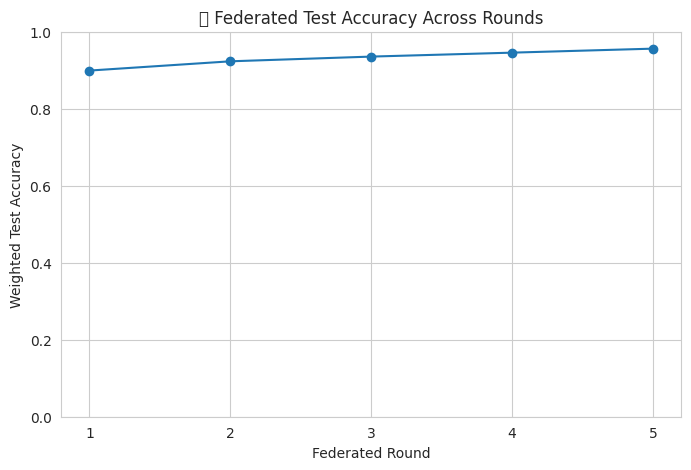

In [71]:
# Plotting accuracy across federated training rounds
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(accuracy_per_round) + 1), accuracy_per_round, marker='o')
plt.title("📈 Federated Test Accuracy Across Rounds")
plt.xlabel("Federated Round")
plt.ylabel("Weighted Test Accuracy")
plt.grid(True)
plt.xticks(range(1, len(accuracy_per_round) + 1))
plt.ylim(0, 1)
plt.show()